/tmp/ipykernel_37597/4056323248.py:27: RuntimeWarning: divide by zero encountered in divide
  term = np.sqrt(l / (p * one_minus_p)) * ((C - R) / denom)


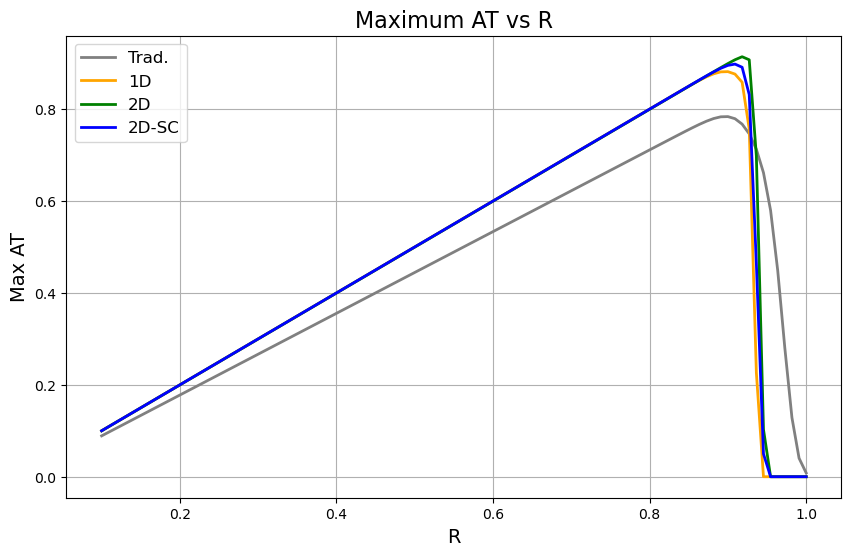

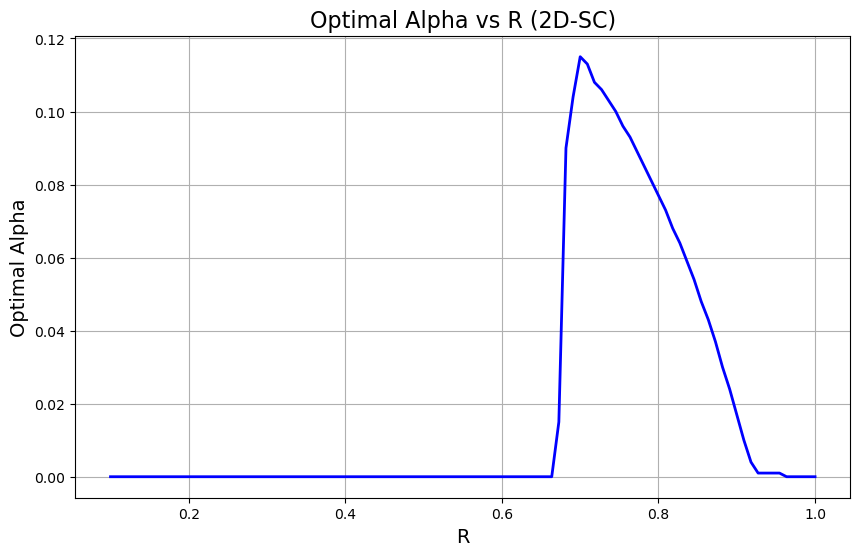

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

# Define Q-function
def qfunc(x):
    return 0.5 * erfc(x / np.sqrt(2))

# Basic SNR functions
def gam(txP, N0):
    return txP / N0

def gam_Super_tag(txP, N0, alpha):
    return (alpha * txP) / ((1 - alpha) * txP + N0)

def gam_Super_msg(txP, N0, alpha):
    return ((1 - alpha) * txP) / (alpha * txP + N0)

# Error rate function
def error_rate(l, R, snr):
    p = qfunc(np.sqrt(2 * snr))
    # Avoid log(0) issues by adding a very small number when needed.
    p = np.where(p == 0, 1e-22, p)
    one_minus_p = 1 - p
    C = 1 + p * np.log2(p) + one_minus_p * np.log2(one_minus_p)
    denom = np.log2(one_minus_p / p)
    term = np.sqrt(l / (p * one_minus_p)) * ((C - R) / denom)
    return qfunc(term)

# Functions for different processing schemes
def Pe_reg(l, P, R, N0):
    return error_rate(l, R, gam(P, N0))

def Pe_t_super(t, m, nc, P, R, N0, alpha):
    return error_rate(t, R * t / (nc * m), gam_Super_tag(P, N0, alpha))

def Pe_m_2D_super(m, R, P, N0, alpha):
    return error_rate(m, R, gam_Super_msg(P, N0, alpha))

# Energy per bit functions
def Em_trad(t, m, R, P):
    return P / R * (1 + t / m)

def Em_1D(t, m, R, P, nr):
    return P / R * (1 + t / (nr * m))

def Em_2D(t, m, R, P, nr, nc):
    return P / R * (1 + ((nr + nc) * t) / (nr * nc * m))

def Em_2D_super(t, m, R, P, nr):
    return P / R * (1 + t / (nr * m))

# Auxiliary functions for 2D schemes
def pr_2D(Pem, Pet, nr, nc):
    return (1 - ((1 - Pem)**(nc - 1) * (1 - Pet))) * (1 - ((1 - Pem)**(nr - 1) * (1 - Pet)))

def pr_2D_super(Pem, Pet, nr, nc, Pet_reg):
    return (1 - ((1 - Pem)**(nc - 1) * (1 - Pet))) * (1 - ((1 - Pem)**(nr - 1) * (1 - Pet_reg)))

# AER functions
def AER_trad(Pem, Pet):
    return 1 - ((1 - Pem) * (1 - Pet))

def AER_1D(Pem, Pet, nr):
    return 1 - (((1 - Pem)**nr) * (1 - Pet))

def AER_2D(Pem, Pet, nr, nc):
    return pr_2D(Pem, Pet, nr, nc) * (1 - Pem) + Pem

def AER_2D_super(Pem, Pet, nr, nc, Pet_reg):
    return pr_2D_super(Pem, Pet, nr, nc, Pet_reg) * (1 - Pem) + Pem

# Throughput functions
def AT_trad(Pem, Pet, m, t, R):
    return (R * m / (m + t)) * ((1 - Pet) * (1 - Pem))

def AT_1D(Pem, Pet, m, t, nr, R):
    return (R * nr * m / (nr * m + t)) * ((1 - Pet) * ((1 - Pem)**nr))

def AT_2D(Pem, Pet, m, t, nr, nc, R):
    return (R * nr * nc * m / (nr * nc * m + (nr + nc) * t)) * ((1 - pr_2D(Pem, Pet, nr, nc)) * (1 - Pem))

def AT_2D_super(Pem, Pet, m, t, nr, nc, Pet_reg, R):
    return (R * nr * m / (nr * m + t)) * ((1 - pr_2D_super(Pem, Pet, nr, nc, Pet_reg)) * (1 - Pem))





def find_optimal_alpha_and_plot_AT(P, N0, m, t, nr, nc):
    R_values = np.linspace(0.1, 1.0, 100)  # Range of R values to evaluate
    alpha_arr = np.arange(0, 0.5 + 0.001, 0.001)  # Range of alpha values

    max_AT_values_super = []  # To store maximum AT for 2D-super scheme
    optimal_alpha_values_super = []  # To store optimal alpha for 2D-super scheme

    max_AT_values_trad = []  # To store maximum AT for traditional scheme
    max_AT_values_1D = []  # To store maximum AT for 1D scheme
    max_AT_values_2D = []  # To store maximum AT for 2D scheme

    for R in R_values:
        # Compute AT for 2D-super scheme
        Pet_super = Pe_t_super(t, m, nc, P, R, N0, alpha_arr)
        Pem_super = Pe_m_2D_super(m, R, P, N0, alpha_arr)
        AT_values_super = AT_2D_super(Pem_super, Pet_super, m, t, nr, nc, Pe_reg(t, P, R, N0), R)

        # Find the maximum AT and corresponding alpha for 2D-super scheme
        max_AT_super = np.max(AT_values_super)
        optimal_alpha_super = alpha_arr[np.argmax(AT_values_super)]

        max_AT_values_super.append(max_AT_super)
        optimal_alpha_values_super.append(optimal_alpha_super)

        # Compute AT for traditional, 1D, and 2D schemes
        Pet_trad = Pe_reg(t, P, R, N0)
        Pem_trad = Pe_reg(m, P, R, N0)
        AT_trad_temp = AT_trad(Pem_trad, Pet_trad, m, t, R)
        max_AT_values_trad.append(AT_trad_temp)

        AT_1D_temp = AT_1D(Pem_trad, Pet_trad, m, t, nr, R)
        max_AT_values_1D.append(AT_1D_temp)

        AT_2D_temp = AT_2D(Pem_trad, Pet_trad, m, t, nr, nc, R)
        max_AT_values_2D.append(AT_2D_temp)

    # Plot AT vs R for all schemes
    plt.figure(figsize=(10, 6))
    plt.plot(R_values, max_AT_values_trad, label="Trad.", color="gray", linewidth=2)
    plt.plot(R_values, max_AT_values_1D, label="1D", color="orange", linewidth=2)
    plt.plot(R_values, max_AT_values_2D, label="2D", color="green", linewidth=2)
    plt.plot(R_values, max_AT_values_super, label="2D-SC", color="blue", linewidth=2)
    plt.xlabel("R", fontsize=14)
    plt.ylabel("Max AT", fontsize=14)
    plt.title("Maximum AT vs R", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

    # Plot optimal alpha vs R for 2D-super scheme
    plt.figure(figsize=(10, 6))
    plt.plot(R_values, optimal_alpha_values_super, label="Optimal Alpha (2D-SC)", color="blue", linewidth=2)
    plt.xlabel("R", fontsize=14)
    plt.ylabel("Optimal Alpha", fontsize=14)
    plt.title("Optimal Alpha vs R (2D-SC)", fontsize=16)
    plt.grid(True)
    plt.show()


# # ----- Set parameters -----
nr = 1000       # number of rows
nc = 200        # number of columns
R = 0.5

m = 1024
t = 128

P = 400
N0 = 100
# Example usage
find_optimal_alpha_and_plot_AT(P=P, N0=N0, m=m, t=t, nr=nr, nc=nc)


























def plot(P_arr, R, m, t, N0, nr, nc, xlimit = None, xlimitAER = None, ylimit = None, ylimitAER = None): 
    # Define the range for Po and alpha

    alpha_arr = np.arange(0, 0.5 + 0.001, 0.001)  # shape (n_alpha,)

    # Compute baseline error probabilities (with alpha = 0)
    Pet = Pe_reg(t, P_arr, R, N0)  # shape (nP,)
    Pem = Pe_reg(m, P_arr, R, N0)  # shape (nP,)

    # Prepare expanded arrays for vectorized computation over P and alpha.
    # P_exp: shape (nP, 1) and alpha_exp: shape (1, n_alpha)
    P_exp = P_arr[:, None]
    alpha_exp = alpha_arr[None, :]

    # Compute 2D-super values over the grid of P and alpha
    Pem_super_vec = Pe_m_2D_super(m, R, P_exp, N0, alpha_exp)  # shape (nP, n_alpha)
    Pet_super_vec = Pe_t_super(t, m, nc, P_exp, R, N0, alpha_exp)  # shape (nP, n_alpha)

    # Compute error rate and throughput for the 2D-super scheme.
    # Note: The baseline Pet (computed with alpha=0) is broadcast along axis 1.
    error_rate_2D_super_vec = AER_2D_super(Pem_super_vec, Pet_super_vec, nr, nc, Pet[:, None])
    throughput_2D_super_vec   = AT_2D_super(Pem_super_vec, Pet_super_vec, m, t, nr, nc, Pet[:, None], R)

    # For each Po value, select the optimal alpha values:
    # For minimum AER, ignore entries where error_rate == 1 by replacing them with np.inf.
    masked_AER = np.where(np.isclose(error_rate_2D_super_vec, 1), np.inf, error_rate_2D_super_vec)
    min_AER = np.min(masked_AER, axis=1)
    min_AER_idx = np.argmin(masked_AER, axis=1)
    min_AER_alpha = alpha_arr[min_AER_idx]

    # For maximum throughput, ignore zeros by replacing them with -infinity.
    masked_throughput = np.where(np.isclose(throughput_2D_super_vec, 0), -np.inf, throughput_2D_super_vec)
    max_Throu = np.max(masked_throughput, axis=1)
    max_Throu_idx = np.argmax(masked_throughput, axis=1)
    max_Throu_alpha = alpha_arr[max_Throu_idx]

    # Compute energy, error rate and throughput for the other schemes (all vectorized over P_arr)
    Eb_trad = Em_trad(t, m, R, P_arr)
    error_rate_trad = AER_trad(Pem, Pet)
    Throu_trad = AT_trad(Pem, Pet, m, t, R)

    Eb_1D = Em_1D(t, m, R, P_arr, nr)
    error_rate_1D = AER_1D(Pem, Pet, nr)
    Throu_1D = AT_1D(Pem, Pet, m, t, nr, R)

    Eb_2D = Em_2D(t, m, R, P_arr, nr, nc)
    error_rate_2D = AER_2D(Pem, Pet, nr, nc)
    Throu_2D = AT_2D(Pem, Pet, m, t, nr, nc, R)

    Eb_2D_super = Em_2D_super(t, m, R, P_arr, nr)

    # ----- Plotting -----
    # Define color palette (each row is an RGB triplet)
    lineColors = np.array([
        [0.3,    0.3,    0.3],    # gray
        [0.95,   0.325,  0.198],   # orange
        [0.325,  0.729,  0.325],   # green
        [0,      0.447,  0.741]    # blue
    ])





    # 1. Min AER vs Eb/N0
    plt.subplot(2, 2, 1)
    ax = plt.gca()  
    ax.set_facecolor(bgc)
    plt.semilogy(10 * np.log10(Eb_trad / N0), error_rate_trad, color=lineColors[0], linewidth=5.5, label="Trad.")
    plt.semilogy(10 * np.log10(Eb_1D / N0), error_rate_1D, color=lineColors[1], linewidth=5.5, label="1D ")
    plt.semilogy(10 * np.log10(Eb_2D / N0), error_rate_2D, color=lineColors[2], linewidth=5.5, label="2D ")
    plt.semilogy(10 * np.log10(Eb_2D_super / N0), min_AER, color=lineColors[3], linewidth=4, label="2D-SC ")


    # Add vertical lines for Eb/N0 when error_rate_trad is 0.1 and 0.0001
    # Eb_N0_dB = 10 * np.log10(Eb_trad / N0)
    # vline_x_0_1 = Eb_N0_dB[np.argmin(np.abs(error_rate_trad - 0.9))]
    # vline_x_0_0001 = Eb_N0_dB[np.argmin(np.abs(error_rate_trad - 0.001))]
    # plt.axvline(x=vline_x_0_1, color='grey', linestyle=':', linewidth=2)
    # plt.axvline(x=vline_x_0_0001, color='grey', linestyle=':', linewidth=2 )

    if xlimitAER is not None:
        plt.xlim(xlimitAER)
    if ylimitAER is not None:
        plt.ylim(ylimitAER)
    # Create a single legend for the entire figure
    handles, labels = ax.get_legend_handles_labels()
    plt.figlegend(handles, labels, loc='upper center', fontsize=20, ncol=4, frameon=True, framealpha=0.9, edgecolor='black', bbox_to_anchor=(0.52, 1.07), prop={'weight': 'bold'})

    #plt.legend(loc='best' ,fontsize = 22)
    plt.ylabel("AER",fontsize = 22)
    plt.xlabel("Eb/N0 (dB)",fontsize = 22)
    plt.grid(True)


    x_trad      = 10 * np.log10(Eb_trad      / N0)
    x_1D        = 10 * np.log10(Eb_1D        / N0)
    x_2D        = 10 * np.log10(Eb_2D        / N0)
    x_2D_super  = 10 * np.log10(Eb_2D_super  / N0)

    y_trad      = Throu_trad
    y_1D        = Throu_1D
    y_2D        = Throu_2D
    y_2D_super  = max_Throu   # 2D-SC 

    def bold_thin(
        x_main, y_main,
        x_other1, y_other1,
        x_other2, y_other2,
        x_other3, y_other3
    ):
        """
        For each point in (x_main, y_main), interpolate the other three curves at x_main[i].
        Then check if y_main[i] is >= all interpolated values.
        Return two arrays: y_main_bold, y_main_thin
        - y_main_bold is y_main where it is max, else NaN
        - y_main_thin is y_main where it is not max, else NaN
        """
        y_main_bold = np.full_like(y_main, np.nan)
        y_main_thin = np.full_like(y_main, np.nan)

        for i in range(len(x_main)):
            xx = x_main[i]
            val_main = y_main[i]

            # Interpolate each other curve at x_main[i]
            val_o1 = np.interp(xx, x_other1, y_other1)
            val_o2 = np.interp(xx, x_other2, y_other2)
            val_o3 = np.interp(xx, x_other3, y_other3)

            # Check if current point is >= all other values
            if val_main >= val_o1 and val_main >= val_o2 and val_main >= val_o3:
                y_main_bold[i] = val_main
            else:
                y_main_thin[i] = val_main

        return y_main_bold, y_main_thin

    # Create bold/thin arrays for each scheme
    y_trad_bold, y_trad_thin     = bold_thin(x_trad,  y_trad,  x_1D,   y_1D,   x_2D,   y_2D,   x_2D_super, y_2D_super)
    y_1D_bold,   y_1D_thin       = bold_thin(x_1D,    y_1D,    x_trad, y_trad, x_2D,   y_2D,   x_2D_super, y_2D_super)
    y_2D_bold,   y_2D_thin       = bold_thin(x_2D,    y_2D,    x_trad, y_trad, x_1D,   y_1D,   x_2D_super, y_2D_super)
    y_2Dsc_bold, y_2Dsc_thin     = bold_thin(x_2D_super,  y_2D_super,  x_trad, y_trad, x_1D,   y_1D,   x_2D,   y_2D)

    # Now we can plot them: thin first, then bold on top
    plt.subplot(2, 2, 2)
    ax = plt.gca()  
    # Setting Background colour yellow 
    ax.set_facecolor(bgc)
    # Thin lines
    plt.plot(x_trad,  y_trad,        "--", color=lineColors[0],  linewidth=1.5, markersize=3, label="Trad. ")
    plt.plot(x_1D,    y_1D,          "--",color=lineColors[1], linewidth=2, markersize=3, label="1D ")
    plt.plot(x_2D,    y_2D,         "--", color=lineColors[2],  linewidth=1.5, markersize=3, label="2D ")
    plt.plot(x_2D_super,  y_2D_super,       "--",color=lineColors[3],   linewidth=1.5, markersize=3, label="2D-SC ")

    # Bold lines
    # # (No labels here to avoid duplicate legend entries.)
    plt.plot(x_trad,        y_trad_bold,      color=lineColors[0],  linewidth=3.5, markersize=5, alpha=0.3)
    plt.plot(x_1D,          y_1D_bold,        color=lineColors[1],  linewidth=3.5, markersize=5.1, alpha=0.3)
    plt.plot(x_2D,          y_2D_bold,        color=lineColors[2],  linewidth=3.5, markersize=5, alpha=0.3)
    plt.plot(x_2D_super,    y_2Dsc_bold,      color=lineColors[3],  linewidth=3.5,  markersize=4, alpha=0.3)

    plt.plot(x_trad,        y_trad_bold,      color=lineColors[0],  linewidth=1.5, markersize=5, )
    plt.plot(x_1D,          y_1D_bold,        color=lineColors[1],  linewidth=1.5, markersize=5.1, )
    plt.plot(x_2D,          y_2D_bold,        color=lineColors[2],  linewidth=1.5, markersize=5, )
    plt.plot(x_2D_super,    y_2Dsc_bold,      color=lineColors[3],  linewidth=1.5,  markersize=4, )


    if xlimit is not None:
        plt.xlim(xlimit)
    if ylimit is not None:
        plt.ylim(ylimit)
    plt.xlabel("Eb/N0 (dB)" ,fontsize = 22)
    plt.ylabel("Auth Throu.",fontsize = 22)
    plt.grid(True)
    #plt.legend(loc = 'best', fontsize = 22)





    # 3. Alpha at Min AER vs Eb/N0
    plt.subplot(2, 2, 3)
    ax = plt.gca()  
    # Setting Background colour yellow 
    ax.set_facecolor(bgc)
    plt.plot(10 * np.log10(Eb_2D_super / N0), min_AER_alpha,
            linewidth=5.5, marker='o', markersize=5, color=lineColors[3])
    plt.xlabel("Eb/N0 (dB)",fontsize = 22)
    plt.ylabel(r'$\alpha$ (min AER)',fontsize = 22)
    plt.xlim(xlimitAER)
    plt.grid(True)

    # 4. Alpha at Max Throughput vs Eb/N0
    plt.subplot(2, 2, 4)
    ax = plt.gca()  
    # Setting Background colour yellow 
    ax.set_facecolor(bgc)
    plt.plot(10 * np.log10(Eb_2D_super / N0), max_Throu_alpha,
            linewidth=5.5, marker='o', markersize=5, color=lineColors[3])
    plt.xlabel("Eb/N0 (dB)",fontsize = 22)
    plt.ylabel(r'$\alpha$ (max Throu.)',fontsize = 22)
    plt.xlim(xlimit)
    plt.grid(True)

    print(f"m = {int(m)}, t = {int(t)}, R = {R}, nr = {nr}, nc = {nc}")
    plt.tight_layout()
    plt.show()

# xlimit = [0, 6]
# # ylimit = [1/10**5, 10]
# xlimitAER = [0, 10.5]
# ylimitAER = [1/10**16, 10]




# try:
#     xlimit[0]
# except:
#     xlimit = None
# try:
#     xlimitAER[0]
# except:
#     xlimitAER = None
# try:
#     ylimit[0]
# except:
#     ylimit = None
# try:
#     ylimitAER[0]
# except:
#     ylimitAER = None


# bgc = "#F6F6F6"

# # ----- Set parameters -----
# nr = 1000       # number of rows
# nc = 200        # number of columns
# R = 0.5
# N0 = 100
# P_arr = np.arange(1, 1700 + 1, .1)         # shape (nP,)
# for m, t in [(128, 128), (256, 128), (512, 128), (1024, 128), (2048, 128), (4096, 128) , (8192, 128)]:
#     plt.figure(figsize=(10, 8), dpi=200)
#     plot(P_arr, R, m/R, t/R, N0, nr, nc, xlimit, xlimitAER, ylimit, ylimitAER)



